In [3]:
import matplotlib

# 设置Matplotlib支持中文字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

C:\Users\Administrator\AppData\Local\Temp\ipykernel_3252\122378734.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


均方误差 (MSE): 48148816855.447296


c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


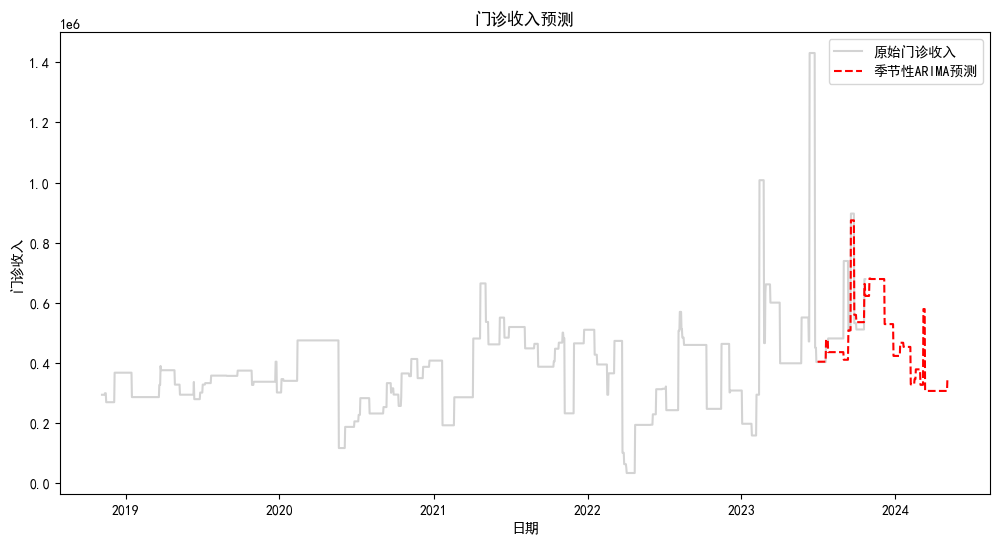

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# 加载数据
data = pd.read_excel('第二问.xlsx')
data['日期'] = pd.to_datetime(data['日期'])
data.set_index('日期', inplace=True)
data = data.asfreq('D')  # 设置日期索引的频率

# 填充缺失数据
data.fillna(method='ffill', inplace=True)

# 定义训练和测试数据
train_data = data[:'2023-06-30']
test_data = data['2023-07-01':'2024-05-04']  # 注意调整测试数据的结束日期为第二问的数据范围

# 构建季节性ARIMA模型，包含外生变量
exog_train = train_data[['门诊患者人次数', '药品总收入', '当日病房收入']]
exog_test = test_data[['门诊患者人次数', '药品总收入', '当日病房收入']]
model_sarima = SARIMAX(train_data['门诊收入OBS_T01_MZSR68'], order=(3, 1, 1), seasonal_order=(0, 0, 1, 12), exog=exog_train)
fitted_model_sarima = model_sarima.fit()

# 进行预测
forecast = fitted_model_sarima.predict(start='2023-07-01', end='2024-05-04', exog=exog_test, typ='levels')  # 结束日期同样需要调整

# 计算均方误差
mse = mean_squared_error(test_data['门诊收入OBS_T01_MZSR68'].dropna(), forecast[test_data['门诊收入OBS_T01_MZSR68'].dropna().index])
print("均方误差 (MSE):", mse)

# 绘制原始数据与预测数据对比图，仅显示预测值
end_date = '2023-10-22'  # 确保绘图截止日期仍然有效
plt.figure(figsize=(12, 6))
plt.plot(data['门诊收入OBS_T01_MZSR68'][:end_date], label='原始门诊收入', color='lightgray')  # 显示原始数据但用淡色表示
plt.plot(forecast, color='red', label='季节性ARIMA预测', linestyle='--')  # 显示所有预测值
plt.title('门诊收入预测')
plt.xlabel('日期')
plt.ylabel('门诊收入')
plt.legend()
plt.show()


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve


# 定义截止日期并按日期过滤数据
end_date = '2023-10-22'
filtered_test_data = test_data[:end_date]['门诊收入OBS_T01_MZSR68'].dropna()
filtered_forecast = forecast[:end_date]

# 定义分类标准：使用门诊收入的中位数作为分类阈值
threshold = data['门诊收入OBS_T01_MZSR68'].median()
test_data_binary = (filtered_test_data > threshold).astype(int)
forecast_binary = (filtered_forecast > threshold).astype(int)

# 计算分类指标
accuracy = accuracy_score(test_data_binary, forecast_binary)
f1 = f1_score(test_data_binary, forecast_binary)
print("准确率 (Accuracy):", accuracy)
print("F1-score:", f1)


准确率 (Accuracy): 1.0
F1-score: 1.0


# LSTM

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 加载数据
data = pd.read_excel('第二问.xlsx')  # 修改为第二问的文件名
data['日期'] = pd.to_datetime(data['日期'])
data.set_index('日期', inplace=True)

# 数据预处理
data.interpolate(method='time', inplace=True)  # 时间序列插值处理缺失值

# 选择特征和目标列
features = ['门诊患者人次数', '药品总收入', '当日病房收入']
target = ['门诊收入OBS_T01_MZSR68']

# 数据归一化
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))
data_scaled_features = scaler_features.fit_transform(data[features])
data_scaled_target = scaler_target.fit_transform(data[target])
data_scaled = np.hstack((data_scaled_features, data_scaled_target))

# 创建时间序列数据集
def create_multivariate_dataset(dataset, look_back=10):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        X.append(dataset[i:(i + look_back), :-1])  # 特征
        Y.append(dataset[i + look_back, -1])       # 目标
    return np.array(X), np.array(Y)

look_back = 10
X, Y = create_multivariate_dataset(data_scaled, look_back)

# 分割数据
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

# 构建LSTM模型
model = Sequential()
model.add(LSTM(256, input_shape=(look_back, X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# 训练模型
model.fit(X_train, Y_train, epochs=100, batch_size=32, verbose=2, validation_split=0.1)


C:\Users\Administrator\AppData\Local\Temp\ipykernel_3252\2077737178.py:15: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='time', inplace=True)  # 时间序列插值处理缺失值


Epoch 1/100
3/3 - 3s - loss: 0.0848 - val_loss: 0.0238 - 3s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0436 - val_loss: 0.0305 - 80ms/epoch - 27ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0275 - val_loss: 0.0221 - 76ms/epoch - 25ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0305 - val_loss: 0.0276 - 74ms/epoch - 25ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0321 - val_loss: 0.0207 - 77ms/epoch - 26ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0252 - val_loss: 0.0174 - 78ms/epoch - 26ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0225 - val_loss: 0.0184 - 76ms/epoch - 25ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0253 - val_loss: 0.0189 - 75ms/epoch - 25ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0225 - val_loss: 0.0170 - 75ms/epoch - 25ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0224 - val_loss: 0.0172 - 75ms/epoch - 25ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0219 - val_loss: 0.0169 - 74ms/epoch - 25ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0219 - val_loss: 0.0170 - 74ms/epoch - 25ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0202 - va

2/2 [==============================] - 0s 5ms/step


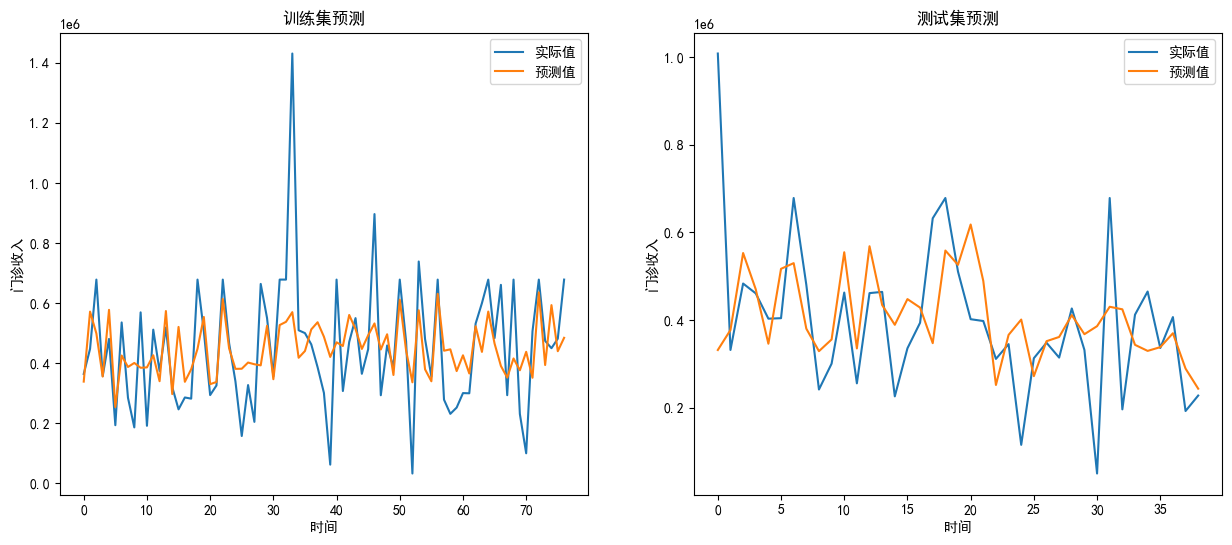

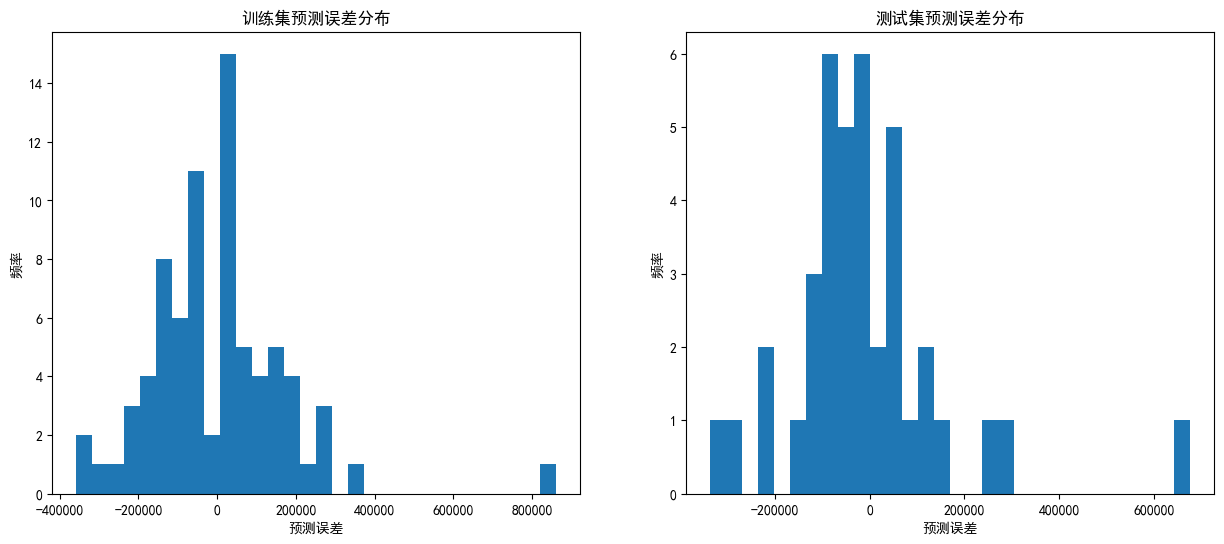

In [23]:
import matplotlib.pyplot as plt

# 进行预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化以获得实际的收入值
train_predict = scaler_target.inverse_transform(train_predict)
test_predict = scaler_target.inverse_transform(test_predict)
Y_train_actual = scaler_target.inverse_transform(Y_train.reshape(-1, 1))
Y_test_actual = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

# 计算预测和实际之间的误差
train_error = Y_train_actual - train_predict
test_error = Y_test_actual - test_predict

# 绘制训练和测试的预测结果
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(Y_train_actual, label='实际值')
plt.plot(train_predict, label='预测值')
plt.title('训练集预测')
plt.xlabel('时间')
plt.ylabel('门诊收入')
plt.legend()

plt.subplot(122)
plt.plot(Y_test_actual, label='实际值')
plt.plot(test_predict, label='预测值')
plt.title('测试集预测')
plt.xlabel('时间')
plt.ylabel('门诊收入')
plt.legend()
plt.show()

# 绘制误差分布图
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(train_error, bins=30)
plt.title('训练集预测误差分布')
plt.xlabel('预测误差')
plt.ylabel('频率')

plt.subplot(122)
plt.hist(test_error, bins=30)
plt.title('测试集预测误差分布')
plt.xlabel('预测误差')
plt.ylabel('频率')
plt.show()


2/2 [==============================] - 0s 4ms/step
准确率 (Accuracy): 0.6923076923076923
F1-score: 0.6666666666666666


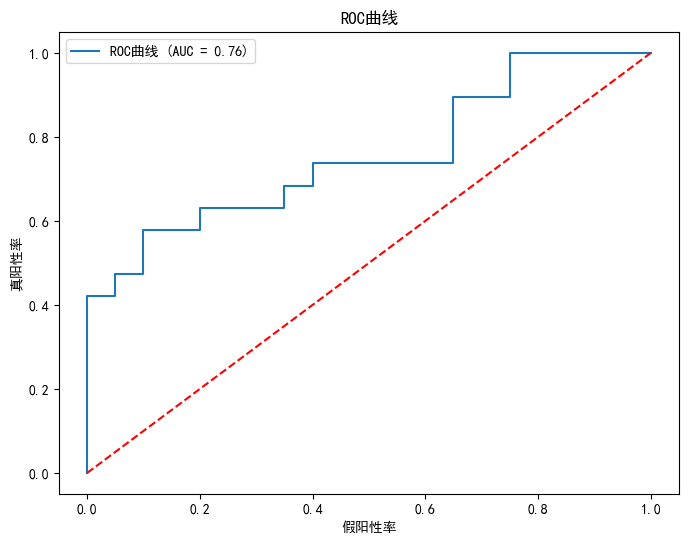

In [24]:
# 预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 反归一化预测结果
train_predict = scaler_target.inverse_transform(train_predict)
test_predict = scaler_target.inverse_transform(test_predict)
Y_train_actual = scaler_target.inverse_transform(Y_train.reshape(-1, 1))
Y_test_actual = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

# 定义分类阈值
threshold = np.median(Y_test_actual)  # 可以调整这个阈值定义

# 创建二进制分类结果
test_data_binary = (Y_test_actual > threshold).astype(int)
forecast_binary = (test_predict > threshold).astype(int)

# 计算准确率和F1-score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve

accuracy = accuracy_score(test_data_binary, forecast_binary)
f1 = f1_score(test_data_binary, forecast_binary)
print("准确率 (Accuracy):", accuracy)
print("F1-score:", f1)

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(test_data_binary, test_predict)
auc = roc_auc_score(test_data_binary, test_predict)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC曲线 (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('ROC曲线')
plt.legend()
plt.show()
